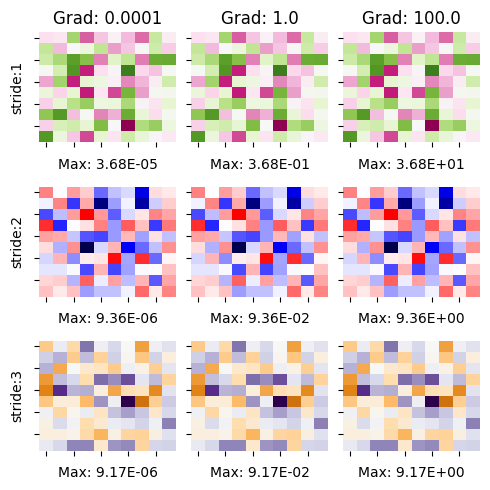

In [25]:
import torch 
from torch.autograd import Variable
import seaborn as sns 
import matplotlib.pyplot as plt 
import copy
strides = [1,2,3]
in_channels=1 
out_channels=12
middle_channels=64
kernel_size=(7,7)
in_size=(10,10)
x = torch.randn(1,1, *in_size)
grad_mult = [0.0001, 1.0, 100.0]
fig, axes = plt.subplots(3, len(strides), figsize=(5, 5))


for i, stride in enumerate(strides):
    conva = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, middle_channels, kernel_size, stride=stride, padding=3, dilation=1, groups=1, bias=False, padding_mode='zeros'),
                torch.nn.ReLU(),
                torch.nn.Conv2d(middle_channels, out_channels, kernel_size, stride=stride, padding=3, dilation=1, groups=1, bias=False, padding_mode='zeros')
        )
    fixed_grad = None 
    for g in range(3):
        input = Variable(x.clone(), requires_grad=True)
        conv = copy.deepcopy(conva)
        output = conv(input)
        if fixed_grad is None:
            fixed_grad = torch.randn_like(output)
        grad = fixed_grad.clone() 
        for c in range(grad.size(1)):
            if c < grad.size(1) //2:
                grad[:,c,...] *= 1/(2**c) * grad_mult[g]
            else:
                grad[:,c,...] *= 0 

        output.backward(gradient=grad,)
        
        cmap = ['PiYG', 'seismic', 'PuOr'][i]
        sns.heatmap(input.grad.detach().view(*in_size), ax=axes[i,g], cbar=False, cmap=cmap, center=0,)
        # axes[g,i].axis("off")
        if g ==0:
            axes[i,g].set_ylabel(f"stride:{stride}")
        if i ==0:
            axes[i,g].set_title(f"Grad: {grad_mult[g]}")
        axes[i,g].set_yticklabels([])
        axes[i,g].set_xticklabels([])
        s = f'Max: {input.grad.detach().max().item():.2E}'
        axes[i,g].set_xlabel(s)
plt.tight_layout()
plt.savefig("outputs/gradient_and_weight_magnitude.pdf")